## Load libraries

In [2]:
import sys

import random
import logging
import time
from tqdm.notebook import tqdm
import pandas as pd
import pickle

sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *
from env_creator import EnvCreator, generate_sdf_rep
from tensor_decomp import apply_tt
from visualization_utils import plot_traj_projections, plot_traj_and_obs_3d

import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from regression import NN_Regressor, GPy_Regressor
from regression import rbf
import numpy.matlib

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

## Load dataset

In [3]:
# exp_name = 'start_goal_fixed_100samples_5'
# exp_name = 'var_start_goal_1000samples_no_waypoint'
exp_name = 'var_start_goal_3000samples'
exp_name = 'var_start_goal_1000samples_no_waypoint'
# exp_name = 'start_goal_fixed_300samples_1'
# exp_name = 'mult_obs_var_start_goal_1000samples_1'
# exp_name = 'mult_obs_var_start_goal_1000samples_teguh'
# exp_name = 'start_goal_fixed_300samples_quadcopter'
# exp_name = 'start_goal_fixed_300samples_1'
# exp_name = 'mult_obs_fixed_start_goal_1000samples'
# exp_name = 'mult_obs_100samples'
# exp_name = '2_obs_var_start_goal_1000samples'
# exp_name = '2_obs_100samples'
# exp_name = 'start_goal_fixed_300samples_1'
# exp_name = 'mult_obs_var_start_goal_500samples_1'

In [4]:
raw_data = load_data(exp_name)

The number of data points: 1000


#### Visualize data in pybullet

In [5]:
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [6]:
obstacles = [{'pos':np.zeros(3), 'rad':0.35}]
x0 = np.ones(3)*-1
x_target = np.ones(3)*1
obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet(x0, x_target, obstacles)

#### Qualitatively assess dataset by randomly sampling data instances 

## Learn from the data

#### Filter the data

Only use the data when the trajectory:
- Has no collision
- Has 'True' as ddp status

In [7]:
status_ddp  = np.array([data['status'] for data in raw_data]) # Trajectories that have 'True' status from ddp
status_col  = np.array([data['collision_status'] for data in raw_data]) # Trajectories that have 'True' status based on collisionfinal_status = status_ddp
final_status = np.logical_and(status_ddp, status_col)
status_ddp, status_col = status_ddp[final_status], status_col[final_status]

#### Extract the useful data

In [8]:
xs_set = np.array([data['xs'][:,:3] for data in raw_data])[final_status]
init_positions = np.array([data['x0'][:3] for data in raw_data])[final_status]
goal_positions = np.array([data['xT'][:3] for data in raw_data])[final_status]
obs_set = np.array([data['obstacles'] for data in raw_data])[final_status]
cost_set = np.array([data['cost'] for data in raw_data])[final_status]

#### Convert environment in SDF representation 

In [9]:
voxel_res = 0.05 # voxel resolution in grid 
tt_rank = 3 # rank for tensor train decomposition -> should be as small as possible
grid_boundaries = \
 np.asarray([(-1,1),   # x
             (-1,1),   # y
             (-1,1)]   # z
            ) # 3x2, columns: (min, max) in world coordinates in meters

env_set = []
tt_env_set = []
full_data = []
for obstacles in obs_set:
#     sdf_vol, tt_sdf_vol, _ = generate_sdf_rep(obstacles, grid_bounds=grid_boundaries, voxel_res=voxel_res, tt_rank=tt_rank)    
    sdf_vol, tt_sdf_vol, tt_sdf_orth, _ = generate_sdf_rep( obstacles, grid_bounds=grid_boundaries, voxel_res=voxel_res, tt_rank=tt_rank)    
    env_set.append(sdf_vol.flatten())
    tt_sdf_vol_array = np.concatenate([f.flatten() for f in tt_sdf_orth])
    tt_env_set.append(tt_sdf_vol_array.flatten()) # factors of the tensor train decomposition of the sdf tensor 

env_set = np.array(env_set)
tt_env_set = np.array(tt_env_set)

In [10]:
# print('Shape of voxel grid: {}'.format(full_data[0]['sdf'].shape))
print('Shape of uncompressed environment data input: {}'.format(env_set.shape))
print('Shape of compressed environment data input: {}'.format(tt_env_set.shape))

Shape of uncompressed environment data input: (869, 64000)
Shape of compressed environment data input: (869, 600)


#### Construct the input output

Current system = point mass 

__input__:
- environment (tt-sdf representation) _or_ obstacle parameters

if dataset with varying start and goal positions additionally: 
- start_position of pointmass 
- target_position of pointmass

__output__:
- path trajectory

In [11]:
use_tt_rep = True # set this variable to use tt_representations as input variables 
start_goal_fixed = False # indicates whether to use start and goal position as additional input 

In [12]:
if use_tt_rep and start_goal_fixed: 
    x_inputs = tt_env_set
elif use_tt_rep and not start_goal_fixed: 
    x_inputs = np.concatenate([tt_env_set, init_positions, goal_positions], axis=1)
else: 
    x_inputs = np.concatenate([r_set[:,None], p_set], axis=1) # use obstacle parametrization instead 

N = len(x_inputs)
D_in = x_inputs.shape[1]
Dx = 3 #dimensions of point mass system (xyz)
T = 101 #number of time steps
print('Number of data instances: {}'.format(N))
print(x_inputs.shape)
x_outputs = xs_set.reshape(N,-1)

Number of data instances: 869
(869, 606)


#### Separate into train and test split

In [13]:
n_samples = len(x_inputs)
indices = np.arange(n_samples)

In [14]:
x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(x_inputs, x_outputs, indices, random_state=3, test_size=0.3)

In [15]:
print('\n',x_train.shape,'\n', y_train.shape,'\n', x_test.shape,'\n', y_test.shape)


 (608, 606) 
 (608, 303) 
 (261, 606) 
 (261, 303)


#### Use Dimensionality Reduction (optional)

In [16]:
use_pca = True
use_rbf = False

if use_pca:
    K = 15
    pca = PCA(n_components=K)
    y_train_pca = pca.fit_transform(y_train)
    y_test_pca = pca.transform(y_test)
    D_out = y_train_pca.shape[1]
elif use_rbf:
    rbf_transform = rbf(D=3, K = 8, offset = 20, width = 15, T = T)
    Phi = rbf_transform.create_RBF()

    plt.plot(Phi)
    plt.show()
    y_train_rbf = rbf_transform.transform(y_train.reshape(-1,T,Dx))
    y_test_rbf = rbf_transform.transform(y_test.reshape(-1,T,Dx))
    D_out = y_train_rbf.shape[1]
else:
    D_out = y_train.shape[1]

#### Save training data

In [17]:
data = dict()
if use_pca:
    data['pca'] = pca
elif use_rbf:
    data['rbf'] = rbf_transform
    
data['x_inputs'] = x_inputs
data['x_outputs'] = x_outputs
data['obstacles'] = obs_set
np.save('training_data/data_'+ exp_name, data)

### Test rbf (if necessary)

In [18]:
#Reconstructed y_train by inverse transform
if use_rbf: 
    y_train_rbf_rec = rbf_transform.inverse_transform(y_train_rbf)

#### Visualize the reconstructed traj

In [19]:
if use_rbf: 
    idx = np.random.randint(len(y_train_rbf_rec))
    y = y_train_rbf_rec[idx]
    y_true = y_train[idx].reshape(-1,Dx)

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(15,5)

    for i in range(3):
        axs[i].plot(y[:,i], '--b', label='Reconstructed')
        axs[i].plot(y_true[:,i], '-r', label='True')
        axs[i].legend()
    plt.show()

## Create & Train model

#### 0. Set predictor

In [20]:
# Set choice of predictor here: 
predictor_dct = {0: 'k-nn', 1: 'gpr', 2:'nn', 3: 'mdn'}
predictor = predictor_dct[1]

#### 1. Neural network

In [21]:
nn = Sequential([
    Dense(256, activation='relu', input_shape=(D_in,)),
    Dense(256, activation='relu'),
    Dense(D_out)
])

In [22]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               155392    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                3855      
Total params: 225,039
Trainable params: 225,039
Non-trainable params: 0
_________________________________________________________________


In [22]:
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mse') # set loss and optimizer 

In [24]:
batch_size = 8
if use_pca:
    history = nn.fit(x_train, y_train_pca,batch_size=batch_size, validation_split=0.2, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])
elif use_rbf:
    history = nn.fit(x_train, y_train_rbf,batch_size=batch_size, validation_split=0.2, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])
else:
    history = nn.fit(x_train, y_train,batch_size=batch_size, validation_split=0.2, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])

Epoch 1/300
213/213 [==============================] - 2s 3ms/step - loss: 1.5399 - val_loss: 1.1698
Epoch 2/300
213/213 [==============================] - 1s 2ms/step - loss: 1.1510 - val_loss: 1.1416
Epoch 3/300
213/213 [==============================] - 0s 2ms/step - loss: 1.1249 - val_loss: 1.0665
Epoch 4/300
213/213 [==============================] - 0s 2ms/step - loss: 1.1017 - val_loss: 1.1095
Epoch 5/300
213/213 [==============================] - 0s 2ms/step - loss: 1.0833 - val_loss: 1.0877
Epoch 6/300
213/213 [==============================] - 1s 2ms/step - loss: 1.0609 - val_loss: 1.0133
Epoch 7/300
213/213 [==============================] - 1s 2ms/step - loss: 1.0521 - val_loss: 1.0555
Epoch 8/300
213/213 [==============================] - 0s 2ms/step - loss: 1.0334 - val_loss: 0.9977
Epoch 9/300
213/213 [==============================] - 0s 2ms/step - loss: 1.0025 - val_loss: 0.9726
Epoch 10/300
213/213 [==============================] - 0s 2ms/step - loss: 0.9963 - val_lo

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
106,0.220397,0.262182,106
107,0.204836,0.256962,107
108,0.204677,0.280185,108
109,0.222959,0.268297,109
110,0.218120,0.291164,110


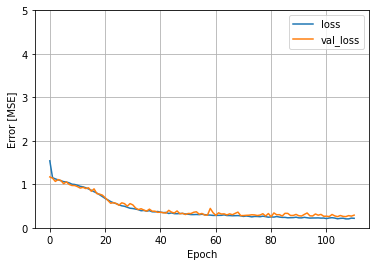

In [26]:
plot_loss(history, y_range=[0,5])

In [27]:
nn.save('model_data/nn_'+exp_name+'.h5')

In [24]:
nn = tf.keras.models.load_model('model_data/nn_'+exp_name+'.h5')

#### 2. k-Nearest Neighbor (knn)

In [25]:
knn = NN_Regressor(K=1)
if use_pca:
    knn.fit(x_train, y_train_pca)
elif use_rbf:
    knn.fit(x_train, y_train_rbf)
else:
    knn.fit(x_train, y_train)

In [26]:
knn.save_to_file('model_data/knn_'+exp_name)

#### 3. Gaussian Process Regressor (GPR)

#### 4 Mixture Density Network (MDN) 

In [23]:
import tensorflow_probability as tfp

In [24]:
tf.keras.backend.set_floatx('float64')

In [25]:
tfd = tfp.distributions
tfpl = tfp.layers

In [37]:
n_comps = 15
n_comp_params_size = tfpl.IndependentNormal.params_size(event_shape=(D_out,))

params_size = tfpl.MixtureSameFamily.params_size(num_components=n_comps, component_params_size=n_comp_params_size)

mdn = Sequential([
    Dense(256, activation='relu', input_shape=(D_in,), kernel_regularizer = tf.keras.regularizers.l2(1e-2)),
    Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-2)),
    Dense(params_size),
    tfpl.MixtureSameFamily(n_comps, tfpl.IndependentNormal(event_shape=(D_out,)))
])

def loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [38]:
mdn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss=loss)

In [39]:
batch_size = 8
if use_pca:
    history = mdn.fit(x_train, y_train_pca,batch_size=batch_size, validation_split=0.1, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)], verbose=1)
elif use_rbf:
    history = mdn.fit(x_train, y_train_rbf,batch_size=batch_size, validation_split=0.1, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])
else:
    history = mdn.fit(x_train, y_train,batch_size=batch_size, validation_split=0.1, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])

Epoch 1/300
69/69 [==============================] - 2s 12ms/step - loss: 40.2933 - val_loss: 20.4628
Epoch 2/300
69/69 [==============================] - 0s 6ms/step - loss: 18.6828 - val_loss: 16.6690
Epoch 3/300
69/69 [==============================] - 0s 5ms/step - loss: 17.3051 - val_loss: 15.8742
Epoch 4/300
69/69 [==============================] - 0s 6ms/step - loss: 15.7882 - val_loss: 14.9571
Epoch 5/300
69/69 [==============================] - 0s 5ms/step - loss: 14.3416 - val_loss: 15.0853
Epoch 6/300
69/69 [==============================] - 0s 6ms/step - loss: 14.2608 - val_loss: 14.0692
Epoch 7/300
69/69 [==============================] - 0s 6ms/step - loss: 13.7746 - val_loss: 13.0384
Epoch 8/300
69/69 [==============================] - 0s 6ms/step - loss: 13.4470 - val_loss: 13.1852
Epoch 9/300
69/69 [==============================] - 0s 6ms/step - loss: 13.3657 - val_loss: 14.6679
Epoch 10/300
69/69 [==============================] - 0s 5ms/step - loss: 12.8537 - val_lo

KeyboardInterrupt: 

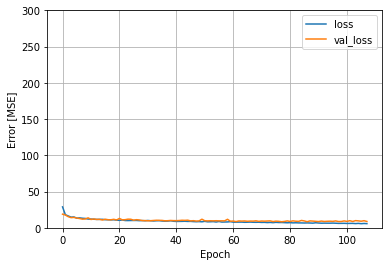

In [40]:
plot_loss(history, y_range= [0,300])

In [41]:
mdn.save_weights('model_data/mdn_'+exp_name)

In [32]:
mdn.load_weights('model_data/mdn_'+exp_name)

## Evaluation 

In [42]:
# Predict
def predict(model, predictor, x, Dx=3, dim_red='pca', n_sample=1, take_mean = False): 
    if predictor == 'gpr':
        y_pred, y_cov = model.predict(x, False)
    elif predictor == 'nn':
        y_pred = model.predict(x)
    elif predictor == 'mdn': 
        if take_mean:
            y_pred = np.transpose(np.array(model(x).components_distribution.mean()), axes=(1,0,2))
        else:
            y_pred = np.array(model(x).sample(n_sample))
            
    elif predictor == 'knn':
        y_pred = model.predict(x)

    #Inverse transform, if using PCA or rbf
    if dim_red == 'pca':
        y_traj = pca.inverse_transform(y_pred)
    elif dim_red == 'rbf':
        y_traj = rbf_transform.inverse_transform(y_pred)
    elif dim_red == None:
        y_traj = np.array(y_pred)
    else: 
        raise NotImplementedError
    return y_traj, y_pred 

### Quantitative

In [43]:
model = mdn # options = {gpr, nn, mdn, knn}
mode = 'mdn'
dim_red = 'pca'

#### MSE (Mean Squared Error)

$\mathrm{MSE}=\frac{1}{n}\sum_{i=1}^n (\hat{y_i} - y_i)^2$

#### MSE, only for MDN

In [59]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(1)

knn.fit(x_train, y_train_pca)

KNeighborsRegressor(n_neighbors=1)

In [61]:
y_traj, _ = predict(model, mode, x_test, dim_red=dim_red, n_sample=100)
y_true = y_test.copy()
batch_error = (y_traj-y_true)**2
batch_total_mse = np.mean(np.min(np.mean(batch_error, axis=-1), axis=0))
batch_goal_mse = np.mean(np.min(np.mean(batch_error[:,:,-3:], axis=-1), axis=0))
print(batch_total_mse, batch_goal_mse)

0.005613878881139728 0.0002865601889248104


In [60]:
y_traj, _ = predict(model, mode, x_test, dim_red=dim_red)
# y_traj = y_traj[0,:,:]
y_true = y_test.copy()

batch_error = (y_traj-y_true)**2
batch_goal_mse = np.mean(batch_error[:,-3:])
batch_total_mse = np.mean(batch_error.reshape(-1, T*Dx))

print(batch_total_mse, batch_goal_mse)

0.03426496667724471 0.011642300929187364


#### Filter based on ddp cost

In [44]:
errors = []
goal_errors = []
col_set = []
true_col_set = []
trajs = []
K = 10
for i in range(20):#len(x_test)): # iterate over all trajectories 
    print(i)
    x = x_test[i]
    y_true = y_test[i].reshape(-1,Dx)
    y_traj, _ = predict(model, mode, x[None,:], dim_red=dim_red, n_sample=K)
    y_traj = y_traj.reshape(K,T,Dx)
    full_idx = test_idx[i]
    obstacles = obs_set[full_idx]
    
    y_traj = get_best_mdn_prediction(y_traj, x, obstacles)
    
    trajs.append(y_traj)
    residuals = np.square(np.subtract(y_traj, y_true))
    errors.append(np.mean(residuals))
    goal_errors.append(residuals[-1])
    
    #check collision
    col_status, _ = eval_collision_geometric(obstacles, y_traj)
    col_set.append(np.max(col_status))

    col_status, _ = eval_collision_geometric(obstacles, y_true)
    true_col_set.append(np.max(col_status))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [45]:
total_mse = np.mean(errors)
goal_mse = np.mean(goal_errors)

print('MSE: \n - total: {:.6f}\n - goal positions: {:.6f}'.format(total_mse, goal_mse))

MSE: 
 - total: 0.076870
 - goal positions: 0.033094


In [172]:
len(x_test)

913

In [173]:
N = len(col_set)

In [174]:
print(np.sum(col_set)/N)

0.050314465408805034


In [175]:
print(np.sum(true_col_set)/N)

0.040880503144654086


#### Try MDN prediction

In [176]:
model = mdn
mode = 'mdn'

In [ ]:
idx = np.random.randint(len(x_test))

In [230]:
x = x_test[idx]
y_true = y_test[idx]
full_idx = test_idx[idx]
obstacles = obs_set[full_idx]
x0, x_target = x[-6:-3], x[-3:]
obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet(x0, x_target, obstacles)


y_traj, _ = predict(model, mode, x[None,:], dim_red=dim_red, n_sample = K)
y_traj = y_traj.reshape(K,T,Dx)

In [231]:
y_traj = get_best_mdn_prediction(y_traj, x, obstacles)
xs_init, us_init = create_lqt_init(lin_sys, y_traj, x0, x_target, 100)

In [232]:
y_traj = xs_init[:,:3]

In [236]:
plot_traj(y_traj, obj_id)

In [238]:
plot_traj(y_true.reshape(-1,Dx), obj_id)

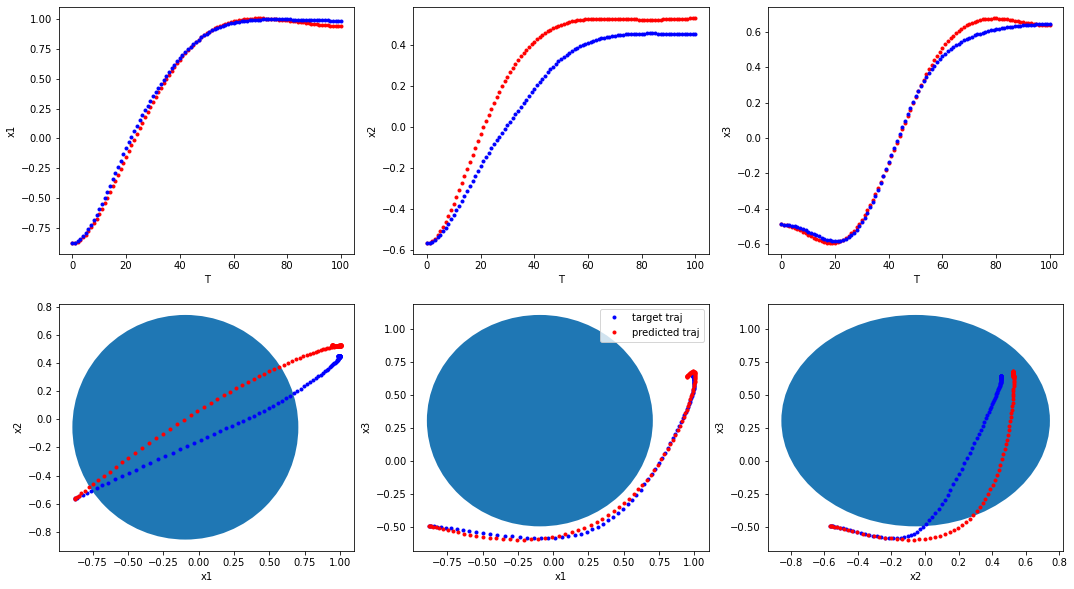

In [239]:
plot_traj_projections(y_true.reshape(-1,Dx), obstacles, y_traj)

#### Collision Cost 

In [42]:
# Create dummy linear system for DDP cost calculation 
dt = 0.05  #duration of 1 time step
Dx_temp, Du = 6, 3 #dimensions of x and u
dof = 3

#Define the matrix A and B to define a double integrator
A = np.eye(Dx_temp)
A[:dof,dof:] = np.eye(dof)*dt
B = np.zeros((Dx_temp, Du))
B[:dof,:] = 0.5*np.eye(Du)*(dt**2)
B[dof:, :] = np.eye(Du)*dt
lin_sys = LinearSystem(A, B)

In [43]:
def eval_collision(obstacles, y_traj, lin_sys):
    '''
    DDP cost formulation 
    '''
    collision_cost = []
    for obs in obstacles: 
        c = CostModelCollisionSphere(lin_sys, obs['pos'], obs['rad'], w_obs=obs['w'], d_margin=obs['d_marg'])
        # sum up costs for each point in trajectory -> should sum up to 0 if no collisions 
        for x in y_traj:  
            u_dummy = np.array([0,0,0])
            collision_cost.append(c.calc(x, u_dummy))
                            
    return np.sum(collision_cost)           

In [44]:
def eval_collision_geometric(obstacles, y_traj, margin=-1e-2): 
    collision_bool = []
    collision_dists = []
    for x in y_traj: 
        collision = False 
        obst_dists = []
        for obs in obstacles:
            p, r = obs['pos'], obs['rad']
            dist = np.linalg.norm(p-x)
            obst_dists.append(dist-r)
            
            if dist < (r+margin): # add a margin to the obstacle surface (at least radius of point mass)
                collision = True 
        collision_bool.append(collision)
        collision_dists.append(np.min(obst_dists))
        
    return np.array(collision_bool), np.array(collision_dists)

In [56]:
approx_cost = [np.round(c, decimals=1) for c in ddp_collision_cost]
ddp_no_collision_inds = np.where(np.asarray(approx_cost) == 0.0)[0]

geom_no_collision_inds = np.where(~np.asarray(geometric_collision_check))[0]
geom_collision_inds = np.where(np.asarray(geometric_collision_check))[0]

In [57]:
print('DDP - Avg. collision cost: %.4f'%np.mean(ddp_collision_cost))
print('DDP - Median collision cost: %.4f'%np.median(ddp_collision_cost))
print('DDP - Share of trajectories with no collisions: %.4f'%(len(ddp_no_collision_inds)/len(ddp_collision_cost)))
print('Geometric - Share of trajectories with no collisions: %.4f'%(1-np.asarray(geometric_collision_check).sum()/len(geometric_collision_check)))

DDP - Avg. collision cost: 44.4255
DDP - Median collision cost: 2.4878
DDP - Share of trajectories with no collisions: 0.4306
Geometric - Share of trajectories with no collisions: 0.6528


In [47]:
print('DDP - Avg. collision cost: %.4f'%np.mean(ddp_collision_cost))
print('DDP - Median collision cost: %.4f'%np.median(ddp_collision_cost))
print('DDP - Share of trajectories with no collisions: %.4f'%(len(ddp_no_collision_inds)/len(ddp_collision_cost)))
print('Geometric - Share of trajectories with no collisions: %.4f'%(1-np.asarray(geometric_collision_check).sum()/len(geometric_collision_check)))

DDP - Avg. collision cost: 29.9906
DDP - Median collision cost: 11.7075
DDP - Share of trajectories with no collisions: 0.1793
Geometric - Share of trajectories with no collisions: 0.4000


In [138]:
print('Avg. dist to surface when collision: %.4f'%np.mean(geometric_collision_dists))

Avg. dist to surface when collision: -0.1440


In [139]:
print('Avg. dist to surface when collision: %.4f'%np.median(geometric_collision_dists))

Avg. dist to surface when collision: -0.1362


### Qualitative 

#### Test single (random) prediction

In [107]:
model = nn
mode = 'nn'

In [108]:
%matplotlib inline

In [109]:
i = 0

In [ ]:
#Obtain random task
plt.close('all')
# idx = np.random.randint(len(x_test))
i = i+1
# for idx in geom_collision_inds[i:i+1]: 
# for idx in geom_no_collision_inds[i:i+1]: 
for idx in range(len(x_test)):
#     if idx in no_collision_inds:
#         print(idx)

    eval_train = False # set to True if evaluation on training set (just for sanity checks!)

    if not eval_train: 
        x = x_test[idx]
        full_data_idx = test_idx[idx] # map idx from test set to full dataset idx 
        y_true = y_test[idx].reshape(-1,Dx)
    else: 
        x = x_train[idx]
        full_data_idx = train_idx[idx] # map idx from test set to full dataset idx 
        y_true = y_train[idx].reshape(-1,Dx)

    y_traj, y_pred = predict(model, mode, x, dim_red=dim_red)

    obstacles = obs_set[idx]
    collision_geom_gt = np.any(eval_collision_geometric(obstacles, y_true)[0])
    collision_geom_pred = np.any(eval_collision_geometric(obstacles, y_traj)[0])
    
    print('ID: %d'%idx)
    print('Number of obstacles: %d'%len(obstacles))

#     print('\nGround truth: \nDDP: Reach target: {}; no collision: {}; overall status: {}'.format(data_sample['target_status'], data_sample['collision_status'], data_sample['status']))
    print('Geometric collision check: no collision = {}'.format(not collision_geom_gt))
    print('\nPrediction: \nGeometric collision check: no collision = {}'.format(not collision_geom_pred))

    #Plot the trajectories
#     plot_traj_projections(y_true, obstacles, y_traj=y_traj)
    # plot_traj_projections(y_train[idx].reshape(-1, 3), obstacles, y_traj=y_train_true[idx].reshape(-1, 3))

    obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet(x0, x_target, obstacles)
    plot_traj(y_traj, obj_id)

In [ ]:
plot_traj(y_traj, obj_id, dt=0.05)

In [184]:
%matplotlib widget

In [ ]:
# show corresponding 3D plot 
data_sample = full_data[idx]
plot_traj_and_obs_3d(data_sample, pred=y_traj)

In [ ]:
# Show in pybullet 
if not use_tt_rep: 
    modify_obstacle(obs_id, x[0], x[1:])
else: 
#     rad = full_data[full_data_idx]['r_obs']
#     pos = full_data[full_data_idx]['p_obs']
    rad = full_data[full_data_idx]['obstacles'][0]['rad']
    pos = full_data[full_data_idx]['obstacles'][0]['pos']
    setup_pybullet(full_data[full_data_idx]['x0'], full_data[full_data_idx]['xT'])
    modify_obstacle(obs_id, rad, pos)
    
plot_traj(y_traj, obj_id) # ,dt=0.05)
# plot_traj(y_true, obj_id)

In [118]:
# does prediction end in goal state? 
goal = y_true[-1,:]
terminal_state = y_traj[-1,:]
goal_divergence = goal - terminal_state
goal_divergence_norm = np.linalg.norm(goal_divergence)

In [119]:
print(goal_divergence)
print(goal_divergence_norm)

[-0.0001  0.0001  0.0013]
0.0012600438284346063
